The idea and the code from http://codereview.stackexchange.com/a/37059/99441 and https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

In [114]:
import sqlite3

from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
import numpy as np
from jellyfish import jaro_distance
from matplotlib import pyplot as plt

from main import get_primitive_authors

In [54]:
%matplotlib inline
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

In [76]:
db_name = '../Database/src/main/resources/test.db'
conn = sqlite3.connect(db_name)
conn.row_factory = sqlite3.Row
cursor = conn.cursor()
primitive_authors = get_primitive_authors(cursor)
primitive_authors_sname = [a['surname'] for a in primitive_authors]
primitive_authors_id = [a['_id'] for a in primitive_authors]

In [101]:
def d(coord):
    i, j = coord
    return 1 - jaro_distance(primitive_authors[i]['surname'], primitive_authors[j]['surname'])

In [102]:
triu_distances = np.apply_along_axis(d, 0, np.triu_indices(len(primitive_authors), 1))
Z = linkage(triu_distances)

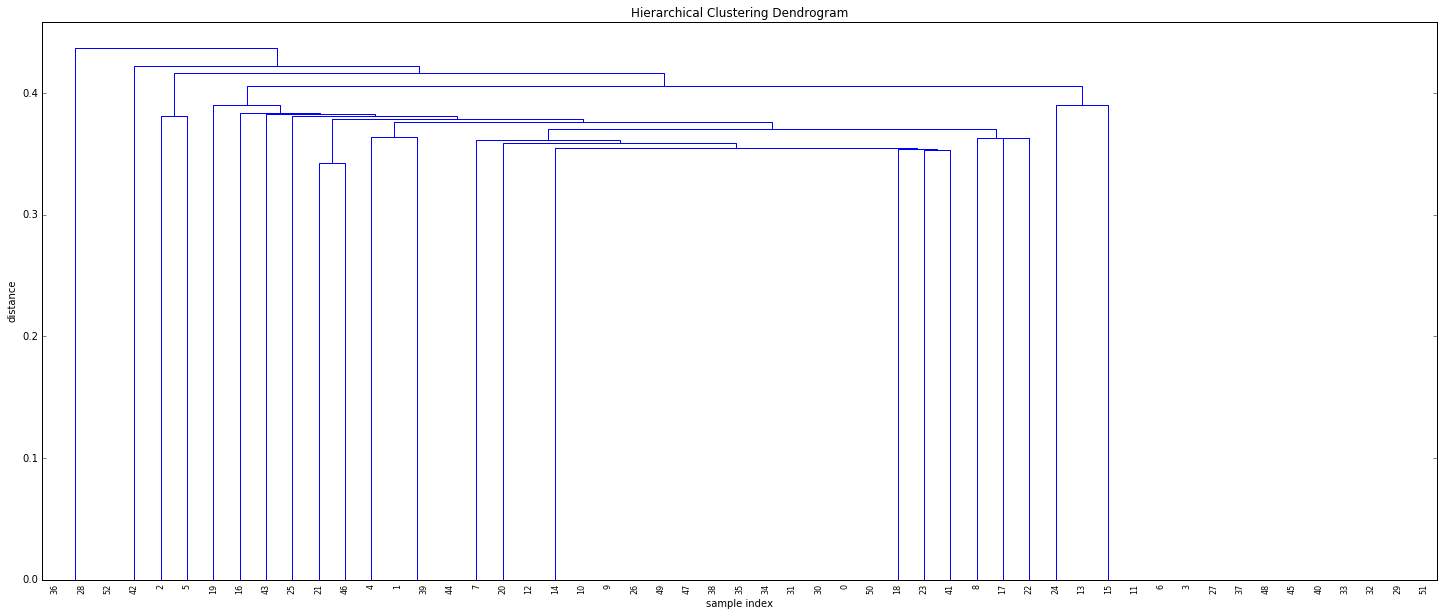

In [72]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [ ]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [ ]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [ ]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

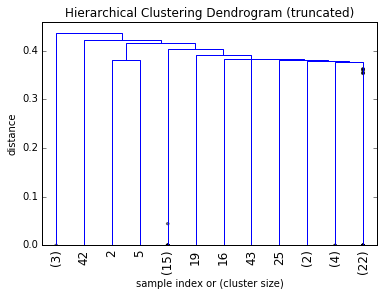

In [104]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

In [73]:
max_d = 0.1

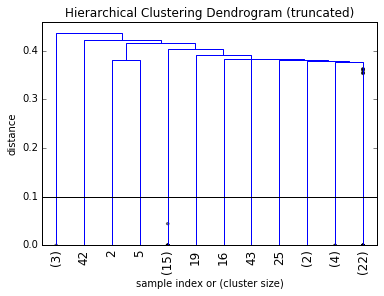

In [105]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,  # plot a horizontal cut-off line
)
plt.show()

In [75]:
max_d = 0.1
clusters = fcluster(Z, max_d, criterion='distance')

In [77]:
primitive_authors = np.array(primitive_authors)
max_index = max(clusters)
clustered = [primitive_authors[np.where(clusters == i)] for i in xrange(1, max_index + 1)]
for c in clustered:
    print c, '\n\n'

[[29 u'Zhou W' u'Zhou, Wei' 9 None u'Zhou, Wei' 0 None]
 [37 u'Zhou W' u'Zhou, Wei' 12 None u'Zhou, Wei' 0 None]
 [53 u'Zhou W' u'Zhou, Wei' 16 None u'Zhou, Wei' 0 None]] 


[[3 u'Rizavi HS' u'Rizavi, Hooriyah S' 3 None u'Rizavi, Hooriyah S' 0 None]] 


[[6 u'Dwivedi Y' u'Dwivedi, Yogesh' 3 None u'Dwivedi, Yogesh' 0 None]] 


[[22 u'Martone ME' u'Martone, Maryann E' 7 None u'Martone, Maryann E' 0
  None]] 


[[47 u'Larson J' u'Larson, John' 14 None u'Larson, John' 0 None]] 


[[2 u'Lugli G' u'Lugli, Giovanni' 3 None u'Lugli, Giovanni' 0 None]
 [40 u'Lugli G' u'Lugli, Giovanni' 13 None u'Lugli, Giovanni' 0 None]
 [45 u'Lugli G' u'Lugli, Giovanni' 14 None u'Lugli, Giovanni' 0 None]] 


[[5 u'Turecki G' u'Turecki, Gustavo' 3 None u'Turecki, Gustavo' 0 None]] 


[[1 u'Smalheiser NR' u'Smalheiser, Neil R' 3 None u'Smalheiser, Neil R' 0
  None]
 [10 u'Smalheiser NR' u'Smalheiser, Neil R' 4 None u'Smalheiser, Neil R' 0
  None]
 [11 u'Smalheiser NR' u'Smalheiser, Neil R' 5 None u'Smalheiser, N

In [110]:
# Disturb some data
primitive_authors = [dict(row) for row in get_primitive_authors(cursor)]
primitive_authors[3]['surname'] = u'Tarvik, Vetle I'
primitive_authors[6]['surname'] = u'Tarviik, Vetle I'

In [111]:
triu_distances = np.apply_along_axis(d, 0, np.triu_indices(len(primitive_authors), 1))
Z = linkage(triu_distances)

In [117]:
c, coph_dists = cophenet(Z, triu_distances)
c

0.95793184578925206

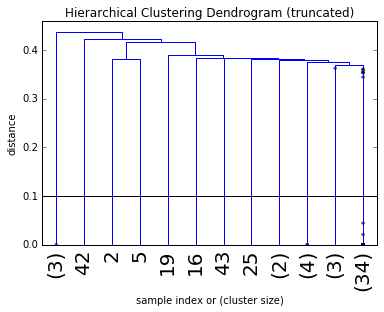

In [118]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,  # plot a horizontal cut-off line
)
plt.show()

In [113]:
max_d = 0.1
clusters = fcluster(Z, max_d, criterion='distance')
np_primitive_authors = np.array(primitive_authors)
max_index = max(clusters)
clustered = [np_primitive_authors[np.where(clusters == i)] for i in xrange(1, max_index + 1)]
for c in clustered:
    print c, '\n\n'

[ {'surname': u'Zhou, Wei', 'name': u'Zhou W', 'encoding': u'Zhou, Wei', 'inference_id': 0, 'source': None, 'author': None, 'article': 9, '_id': 29}
 {'surname': u'Zhou, Wei', 'name': u'Zhou W', 'encoding': u'Zhou, Wei', 'inference_id': 0, 'source': None, 'author': None, 'article': 12, '_id': 37}
 {'surname': u'Zhou, Wei', 'name': u'Zhou W', 'encoding': u'Zhou, Wei', 'inference_id': 0, 'source': None, 'author': None, 'article': 16, '_id': 53}] 


[ {'surname': u'Rizavi, Hooriyah S', 'name': u'Rizavi HS', 'encoding': u'Rizavi, Hooriyah S', 'inference_id': 0, 'source': None, 'author': None, 'article': 3, '_id': 3}] 


[ {'surname': u'Dwivedi, Yogesh', 'name': u'Dwivedi Y', 'encoding': u'Dwivedi, Yogesh', 'inference_id': 0, 'source': None, 'author': None, 'article': 3, '_id': 6}] 


[ {'surname': u'Martone, Maryann E', 'name': u'Martone ME', 'encoding': u'Martone, Maryann E', 'inference_id': 0, 'source': None, 'author': None, 'article': 7, '_id': 22}] 


[ {'surname': u'Larson, John', 'na